In [109]:
import sys; sys.path.append('..')
import numpy as np

from firelab.config import Config

from src.models.classifier import ResnetClassifier
from src.dataloaders import cub

DEVICE = 'cuda'

base_config = Config.load('../configs/base.yml', frozen=False)
curr_config = Config.load('../configs/multi_proto.yml', frozen=False)
config = base_config.overwrite(curr_config).all
config.hp.pretrained =True
config.hp.head.num_prototypes = 10
config.hp.head.noise.std = 0.1
config.hp.head.noise.transform_layers = (32,)
# config.all.hp.model.set('pretrained', True)
# config.all.hp.model.set('num_classes', NUM_CLASSES)
# config.all.hp.model.resnet_type = 'mnist_1d'
# config.all.hp.model.learn_prior = True
attrs = cub.load_class_attributes('../data/CUB_200_2011').astype(np.float32)

model = ResnetClassifier(config, attrs)

In [111]:
model.head.model.fuser.model.weight.norm(dim=0)[:312].mean()

tensor(0.7160, grad_fn=<MeanBackward0>)

In [112]:
model.head.model.fuser.model.weight.norm(dim=0)[312:].mean()

tensor(0.6949, grad_fn=<MeanBackward0>)

(task 2) attr mean norm: 220.60325622558594
(task 2) z mean norm: 22.435062408447266
(task 6) attr mean norm: 222.23422241210938
(task 6) z mean norm: 22.319272994995117
(task 10) attr mean norm: 223.3827667236328
(task 10) z mean norm: 22.23542022705078


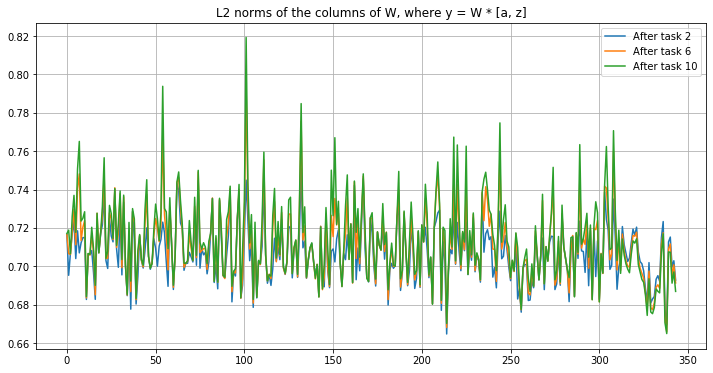

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('L2 norms of the columns of W, where y = W * [a, z]')

for task_id in [1, 5, 9]:
    model_path = f'../experiments/multi_proto-cub-758b4b39df-1-00001/checkpoints/model-task-{task_id}.pt'
    model.load_state_dict(torch.load(model_path))

    print(f'(task {task_id+1}) attr mean norm:', model.head.model.fuser.model.weight.norm(dim=0)[:312].sum().item())
    print(f'(task {task_id+1}) z mean norm:', model.head.model.fuser.model.weight.norm(dim=0)[312:].sum().item())
    
    plt.plot(model.head.model.fuser.model.weight.norm(dim=0).detach(), label=f'After task {task_id+1}');
    #plt.imshow(model.head.model.fuser.model.weight.detach().T, label=f'Task {task_id}')
    
plt.grid()
plt.legend()

In [75]:
prototypes = model.head.model.generate_prototypes()

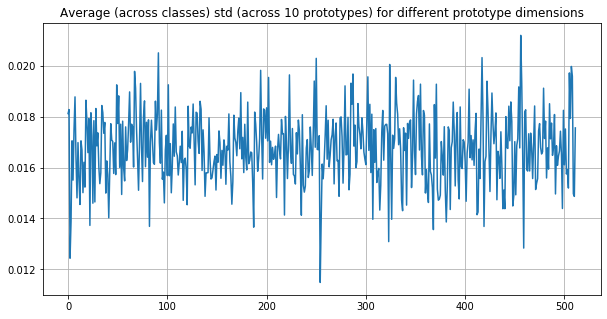

In [104]:
plt.figure(figsize=(10, 5))
plt.title('Average (across classes) std (across 10 prototypes) for different prototype dimensions')
plt.plot(prototypes.std(dim=0).mean(dim=0).detach())
plt.grid();